C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
Best Score: 0.8534274193548388
Classification Report:
              precision    recall  f1-score   support

    Dementia       0.83      0.62      0.71        16
          HC       0.89      0.91      0.90        82
         MCI       0.80      0.83      0.82        59

    accuracy                           0.85       157
   macro avg       0.84      0.79      0.81       157
weighted avg       0.85      0.85      0.85       157



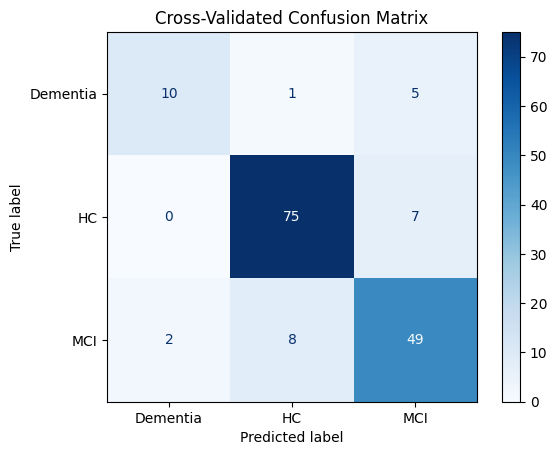

In [4]:
import os
import re
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Helper function to extract data from text files
def load_data(file_pattern, base_path):
    data = []
    record_ids = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if re.match(file_pattern, file):
                with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                    data.append(f.read())
                match = re.search(r'(Process-rec-\d{3})', file)
                if match:
                    record_ids.append(match.group(1))
    return data, record_ids

# Helper function to load labels
def load_labels(label_file):
    df = pd.read_csv(label_file)
    return df.set_index('Record-ID')[['Class', 'Age', 'Converted-MMSE']]  # Removed 'Gender'

# Feature engineering: Calculate text and timing features
def count_interrupters_and_clean_text(text):
    interrupter_count = len(re.findall(r'\(.*?\)', text))  # Count interruptions in parentheses
    cleaned_text = re.sub(r'\(.*?\)', '', text)  # Remove parentheses content
    return interrupter_count, cleaned_text

def find_repetitions_and_timing(text):
    interrupter_count, cleaned_text = count_interrupters_and_clean_text(text)
    words = re.findall(r'\b\w+\b', cleaned_text)
    stutter_words = len(re.findall(r'\b(er|um|oh|ah|mm)\b', cleaned_text))
    meaningful_words = len(words) - stutter_words
    unique_words = len(set(words))
    word_count = len(words)
    return {
        'word_count': word_count,
        'stutter_words': stutter_words,
        'meaningful_words': meaningful_words,
        'unique_words': unique_words,
        'interrupter_count': interrupter_count,
    }

def extract_features(texts):
    return pd.DataFrame([find_repetitions_and_timing(text) for text in texts])

# Load and combine data for CTD, PFT, and SFT
base_path = "../process/PROCESS-V1/"
file_patterns = {
    'CTD': r"Process-rec-\d+__CTD\.txt",
    'PFT': r"Process-rec-\d+__PFT\.txt",
    'SFT': r"Process-rec-\d+__SFT\.txt"
}
data_dict = {}
record_ids_dict = {}

for key, pattern in file_patterns.items():
    data, record_ids = load_data(pattern, base_path)
    data_dict[key] = data
    record_ids_dict[key] = record_ids

label_file = "../process/PROCESS-V1/dem-info-filled-mmse-score.csv"
labels = load_labels(label_file)

# Combine CTD, PFT, and SFT data
combined_data = []
for record_id in labels.index:
    if all(record_id in record_ids_dict[key] for key in file_patterns):
        ctd_text = data_dict['CTD'][record_ids_dict['CTD'].index(record_id)]
        pft_text = data_dict['PFT'][record_ids_dict['PFT'].index(record_id)]
        sft_text = data_dict['SFT'][record_ids_dict['SFT'].index(record_id)]
        row = labels.loc[record_id]
        combined_data.append({
            'Record-ID': record_id,
            'CTD_Text': ctd_text,
            'PFT_Text': pft_text,
            'SFT_Text': sft_text,
            'Class': row['Class'],
            'Age': row['Age'],
            'Converted-MMSE': row['Converted-MMSE'],
        })

# Create DataFrame
df = pd.DataFrame(combined_data)

# Encode Class as labels (target)
df['Class'] = df['Class'].astype('category').cat.codes
class_weights = df['Class'].value_counts(normalize=True).to_dict()
for key in class_weights:
    class_weights[key] = 1.0 / class_weights[key]

df.dropna(inplace=True)

# Combine all text for calculated feature extraction
df['Combined_Text'] = df['CTD_Text'] + ' ' + df['PFT_Text'] + ' ' + df['SFT_Text']

# Prepare features and labels
X_combined_text = df['Combined_Text']
X_numeric = df[['Age', 'Converted-MMSE']]
y = df['Class']

# Extract text features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_text_features = tfidf_vectorizer.fit_transform(X_combined_text)

# Extract calculated features
X_calculated_features = extract_features(X_combined_text).reset_index(drop=True)

# Combine all features
X_combined = pd.concat([
    pd.DataFrame(X_text_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out()),
    #X_calculated_features,
    X_numeric.reset_index(drop=True)
], axis=1)

# Update and fit pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', MinMaxScaler(), X_numeric.columns.tolist() + X_calculated_features.columns.tolist()),
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Perform cross-validation and collect predictions
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__gamma': [0, 1, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_combined, y)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Cross-validated predictions
y_pred = cross_val_predict(grid_search.best_estimator_, X_combined, y, cv=5)

# Evaluate the model
print("Classification Report:")
print(classification_report(y, y_pred, target_names=labels['Class'].astype('category').cat.categories.tolist()))

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels['Class'].astype('category').cat.categories.tolist())
disp.plot(cmap=plt.cm.Blues)
plt.title("Cross-Validated Confusion Matrix")
plt.show()
